# Objective

This notebook is a continuation of the Bayesian decision with Gaussians one, but in an unsupervised setting. We reuse the same dummy 2-d data but without considering their classes. 

We will perform soft clustering based on Gaussian Mixture Models (GMM) trained with the Expectation Maximization algorithm monitorized by a loss function based on the variational lower bound.

For math details, the following links are great resources:

https://brilliant.org/wiki/gaussian-mixture-model/

http://www.lx.it.pt/~mtf/Figueiredo_EM_Algorithm.pdf

In particular, the update formulae for GMM can be found page 27 in Figueiredo's tutorial.

This notebook is based on an assignment given in the Coursera MOOC "Bayesian Methods for Machine Learning": https://www.coursera.org/learn/bayesian-methods-in-machine-learning/


In [175]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
from math import pi as PI

from scipy.stats import norm
%matplotlib inline

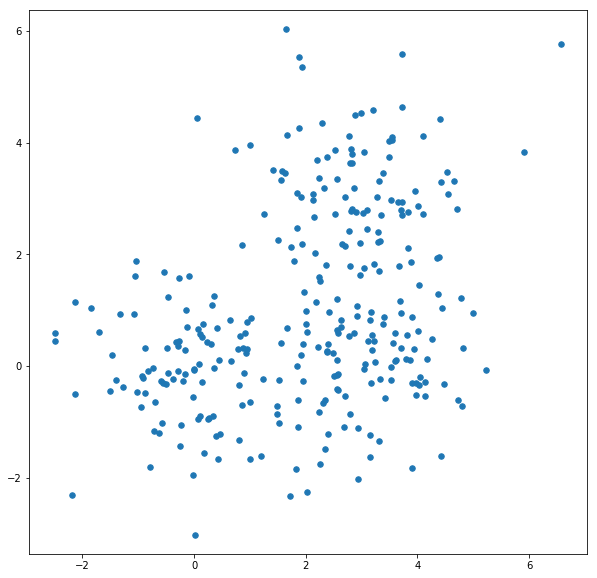

In [182]:
samples = np.load('samples.npz')
X = samples['samples']

C, N_per_class, d = X.shape
X = np.reshape(X, (C*N_per_class, d))
y=np.concatenate((np.zeros((N_per_class,)), np.ones((N_per_class,)), 2*np.ones((N_per_class,))))
N = X.shape[0]

plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], s=30)
plt.axis('equal')
plt.show()

# Expectation-maximization algorithm

## Implementing EM for GMM

For debugging we will use samples from gaussian mixture model with unknown mean, variance and priors. 

The EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{P(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned. $T_i$ (cluster index for object $i$) is a binary vector with only one active bit in position corresponding to the true component. For example, if we have $C=3$ components and object $i$ lies in first component, $T_i = [1, 0, 0]$.

The joint distribution can be written as follows: $p(T, X \mid \theta) =  \prod\limits_{i=1}^N p(T_i, X_i \mid \theta) = \prod\limits_{i=1}^N \prod\limits_{c=1}^C [\pi_c \mathcal{N}(X_i \mid \mu_c, \Sigma_c)]^{T_{ic}}$.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q(T) = p(T|X, \theta)$. We will assume that $T_i$ (cluster index for object $i$) is a binary vector with only one '1' in position corresponding to the true component. To do so we need to compute $\gamma_{ic} = P(T_{ic} = 1 \mid X, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


<b>Important trick 1:</b> It is important to avoid numerical errors. At some point we have to compute the formula of the following form: $\frac{e^{x_i}}{\sum_j e^{x_j}}$. When we compute exponents of large numbers, we get huge numerical errors (some numbers will simply become infinity). We can avoid this by dividing numerator and denominator by $e^{\max(x)}$: $\frac{e^{x_i-\max(x)}}{\sum_j e^{x_j - \max(x)}}$. After this transformation maximum value in the denominator will be equal to one. All other terms will contribute smaller values. So, to compute desired formula we first subtract the maximum value from each component in vector $X$ and then compute everything else as before.

<b>Important trick 2:</b> We need to compute a formula of the form $A^{-1}x$ at some point. We would normally inverse $A$ and then multiply it by $x$. A bit faster and more numerically accurate way to do this is to solve the equation $Ay = x$. Its solution is $y=A^{-1}x$, but the equation $Ay = x$ can be solved by Gaussian elimination procedure. We can use ```np.linalg.solve``` for this.

<b>Other useful functions: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet```</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det```</a>

<b>Task 1:</b> Implement E-step for GMM using template below.

In [177]:
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)
    
    # compute the C determinants of the covariance matrices
    dets = []
    for c in range(C):
        sign, logdet = np.linalg.slogdet(sigma[c])
        dets.append(np.exp(sign * logdet))
    
    for i in range(N):
        # tile x to shape C x d and center
        x = np.tile(X[i], (C,1))
        # print(x.shape, mu.shape)
        x -= mu
        
        # compute z = -0.5*(X-mu).T sigma_c^-1 (X-mu) for a given c
        exp_args = []
        for c in range(C):
            # to compute sigma_c^-1 (X-mu), we find y solving A y = b with A=sigma_c and b=X-mu
            right_term_z = np.linalg.solve(sigma[c], x[c])
            exp_arg = -0.5*np.dot(x[c], right_term_z)
            exp_args.append(exp_arg)
        
        # substract max(z) to avoid overflow
        max_exp_args = max(exp_args)
        exp_args -= max_exp_args
        
        z = []
        for c in range(C):
            p_ic =  1./np.sqrt(((2*PI)**C)*dets[c]) * np.exp(exp_args[c])
            p_ic *= pi[c]
            z.append(p_ic)

        # normalize
        gamma[i] = z / sum(z)
    
    return gamma

Let's try with random initial values for $\pi, \mu, \Sigma$ with $C=3$ components.

In [253]:
# for reproductibility, set a seed
np.random.seed(1234)

### dimensions
# pi: (C)
# mu: (C x d)
# sigma: (C x d x d)

pi0 = np.random.uniform(low=0.0, high=1.0, size=C)
pi0[-1] = 1.-np.sum(pi0[:-1]) # the coefficients must sum to 1.

# initialize mu either with random data points
# mu_ind = np.random.choice(X.shape[0], size=C, replace=False)
# mu0 = X[mu_ind]
# or with a uniform distribution
mu0 = np.random.uniform(low=-1.0, high=1.0, size=(C, 2))

# initialize Sigma either with the identity matrix 
# sigma0 = np.tile(np.eye(d)[np.newaxis,:,:], (C,1,1))

# or with a random semi-positive symmetric matrix
sigma0 = np.random.randn(C,2,2)
for i in range(C):
    sigma0[i] = np.dot(sigma0[i].T, sigma0[i])

Let's plot the clusters obtained with these random initializations. We will assign a cluster label as the most probable cluster index. This can be found using matrix $\gamma$ computed on an E-step. 

We should get random clusters.

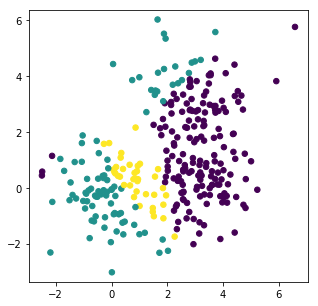

In [255]:
gamma = E_step(X, pi0, mu0, sigma0)
labels = gamma.argmax(1)

plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()

Indeed, they look random!

### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, we need to compute the derivatives and 
set them to zero. We start by deriving formulas for $\mu$ as it is the easiest part. Then move on to $\Sigma$. Here it is crucial to optimize function w.r.t. to $\Lambda = \Sigma^{-1}$ and then inverse obtained result. Finaly, to compute $\pi$, we need <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">Lagrange Multipliers technique</a> to satisfy constraint $\sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Important note:</b> We need to compute derivatives of scalars with respect to matrices. To refresh this technique from previous courses, see <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> wiki article</a> about it . Main formulas of matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>. For example, we find that $\frac{\partial}{\partial A}\log |A| = A^{-T}$.


Solutions: 

At iteration $t+1$, and for each class $c$:

$$\hat \pi_c^{(t+1)} = \displaystyle \frac{1}{N}\sum_{i=1}^{N}\gamma_{ic}$$

$$\hat \mu_c^{(t+1)} = \displaystyle \frac{\displaystyle \sum_{i=1}^{N}\gamma_{ic}x_i}{\displaystyle\sum_{i=1}^{N}\gamma_{ic}}$$

$$\hat \Sigma_c^{(t+1)} = \displaystyle \frac{\displaystyle \sum_{i=1}^{N}(x_i-\hat \mu_c^{(t+1)})(x_i-\hat \mu_c^{(t+1)})^t\gamma_{ic}}{\displaystyle\sum_{i=1}^{N}\gamma_{ic}} $$

see page 27 of http://www.lx.it.pt/~mtf/Figueiredo_EM_Algorithm.pdf: "The update equations for the mean vec-
tors and the covariance matrices are weighted versions of the standard ML
estimates (sample mean and sample covariance)."

In [185]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    # update pi
    pi = 1./N * np.sum(gamma, axis=0)
    
    # update mu
    deno = np.tile(np.sum(gamma, axis=0)[:, np.newaxis], (1,d))
    mu = np.dot(gamma.T, X) * 1. / deno
    
    # update sigma
    sigma = np.zeros((C, d, d))
    for c in range(C):
        
        x_centered_c = X - mu[c]
        gamma_c = gamma[:,c]
        deno = np.sum(gamma_c, axis=0)
        gamma_c = np.tile(gamma_c[:, np.newaxis], (1, d))
        
        x_gamma = np.multiply(x_centered_c, gamma_c)
        sigma[c] = np.dot(x_gamma.T, x_centered_c) * 1. / deno

    return pi, mu, sigma

In [187]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)

### Loss function

Finally, we need some function to track convergence. We will use the variational lower bound $\mathcal{L}$ for this purpose. We will stop the EM iterations when $\mathcal{L}$ will saturate. Usually, we will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, we have a bug in our code.

$$\mathcal{L} = \sum_{i=1}^{N} \sum_{c=1}^{C} \mathbb{E}[t_{i, c}] (\log \pi_c + \log \mathcal{N}(x_i | \mu_c, \sigma_c)) - \sum_{i=1}^{N} \sum_{c=1}^{C} \mathbb{E}[t_{i, c}] \log \mathbb{E}[t_{i, c}]$$

Let's extend this expression:

$$\mathcal{L} = \sum_{n=1}^{N} \sum_{c=1}^{C} q(t_i=c)\Big[\log \pi_c + \log \displaystyle \frac{1}{(2\pi)^{C/2}|\Sigma_c|^{1/2}}\,\exp\big(-\frac{1}{2}(x_i-\mu_c)^t\Sigma_c^{-1}(x_i-\mu_c)\big)\Big] - \sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i=c) \log q(t_i=c)$$

After simplification, we have:

$$\mathcal{L} = \sum_{n=1}^{N} \sum_{c=1}^{C} q(t_i=c)\Big[\log \pi_c - \displaystyle \frac{d}{2}\log 2\pi -\frac{1}{2}|\Sigma_c| -\frac{1}{2}(x_i-\mu_c)^t\Sigma_c^{-1}(x_i-\mu_c)\Big] - \sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i=c) \log q(t_i=c)$$

$$\mathcal{L} = \sum_{n=1}^{N} \sum_{c=1}^{C} q(t_i=c)\Big[\log \pi_c - \log q(t_i=c) - \displaystyle \frac{d}{2}\log 2\pi -\frac{1}{2}|\Sigma_c| -\frac{1}{2}(x_i-\mu_c)^t\Sigma_c^{-1}(x_i-\mu_c)\Big]$$




In [189]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    # expectation relative to pi: Sum_i Sum_c gamma*log(pi_c)
    expec_log_pi_c = np.sum(np.multiply(gamma, np.tile(np.log(pi[np.newaxis,:]), (N,1))))
    
    # expectation relative to (2*PI)^d/2 det(Sigma_c)
    # compute the C determinants of the covariance matrices
    dets = []
    for c in range(C):
        sign, logdet = np.linalg.slogdet(sigma[c])
        dets.append(np.exp(sign * logdet))
    dets = np.array(dets, dtype=np.float32)
    expec_log_det_sigma_c = -0.5*d*np.log(2*PI)*N - \
    0.5*np.sum(np.multiply(gamma, np.log(np.tile(dets[np.newaxis,:], (N,1)))))
    
    # expectation relative to the exp term
    expec_exp = 0
    for i in range(N):
        # tile x to shape C x d and center
        x = np.tile(X[i], (C,1))
        x -= mu

        # compute z = -0.5*(X-mu).T sigma_c^-1 (X-mu) for a given c
        for c in range(C):
            # to compute sigma_c^-1 (X-mu), we find y solving A y = b with A=sigma_c and b=X-mu
            right_term_z = np.linalg.solve(sigma[c], x[c])
            exp_arg = -0.5*np.dot(x[c], right_term_z)
            expec_exp += exp_arg * gamma[i,c]
    
    # expectation relative to gamma
    expec_gamma = -np.sum(np.multiply(gamma, np.log(gamma)))
    
    loss = expec_log_pi_c + expec_log_det_sigma_c + expec_exp + expec_gamma
    
    return loss

In [190]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
print(loss)
# grader.submit_VLB(loss)

-1167.80631686


### Bringing it all together

Now that we have E step, M step and VLB, we can implement the training loop. We will start with random values of $\pi$, $\mu$ and $\Sigma$, train until $\mathcal{L}$ stops changing and return the resulting points. We also know that EM algorithm sometimes stops at local optima. To avoid this we should restart algorithm multiple times from different starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Remember that values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to simply restart the procedure.


In [191]:
pi = np.random.uniform(low=0.0, high=1.0, size=3)
pi[-1] = 1.-np.sum(pi[:-1])
pi, np.sum(pi)

(array([ 0.22159413,  0.15836857,  0.6200373 ]), 1.0)

In [289]:
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10, seed=None):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    
    if seed is not None: np.random.seed(seed)
        
    for _ in range(restarts):
        try:

            pi = np.random.uniform(low=0.0, high=1.0, size=C)
            pi[-1] = 1.-np.sum(pi[:-1])
            assert np.isclose([np.sum(pi)], [1.0]), "error while initializing pi"
            # print(pi.shape)
            
            ### initialize mu either with random data points
            mu_ind = np.random.choice(X.shape[0], size=C, replace=False)
            mu = X[mu_ind]
            ### or with a uniform distribution
            # mu = np.random.uniform(low=-1.0, high=1.0, size=(C, 2))
            ### or with a normal distribution
            # sigma_X = np.std(X)
            # mu_X = np.mean(X)
            # mu = sigma_X*np.random.randn(C, 2) + mu_X
            
            ### initialize Sigma either with the identity matrix 
            sigma = np.tile(np.eye(d)[np.newaxis,:,:], (C,1,1))

            # or with a random semi-positive symmetric matrix
            # sigma = np.random.randn(C,2,2)
            # for i in range(C):
            #     sigma[i] = np.dot(sigma[i].T, sigma0[i])
    
            gamma = E_step(X, pi, mu, sigma)
            prev_loss = compute_vlb(X, pi, mu, sigma, gamma)
            print('init', prev_loss)
            
            converged = False
            it=0
            while not converged:
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                
                ratio = np.abs((loss-prev_loss)/prev_loss)
                print(it, loss, ratio)
                it+=1
                converged = it>max_iter or ratio < rtol
                prev_loss = loss
             
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass
        
        if best_loss is None:
            best_loss = loss
            best_pi = pi
            best_mu = mu
            best_sigma = sigma
        elif loss > best_loss:
            best_loss = loss
            best_pi = pi
            best_mu = mu
            best_sigma = sigma
                        
    return best_loss, best_pi, best_mu, best_sigma

In [290]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3, seed=123)

init -1996.69503395
0 -1155.32125367 0.421383218757
1 -1150.47273893 0.00419668099115
2 -1146.58117092 0.00338258167818
3 -1142.10569319 0.00390332393517
4 -1137.07288778 0.00440660216067
5 -1132.02769147 0.004437003435
6 -1127.38734145 0.00409914885721
7 -1123.23847164 0.00368007485485
8 -1120.3156744 0.0026021163938
9 -1119.19511122 0.00100022092294
10 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log


-1118.86832576 0.000291982568777
init nan
0 nan nan
1 -1132.48424818 nan
2 -1124.85365505 0.00673792429215
3 -1122.8913083 0.0017445351645
4 -1121.52339109 0.00121820981309
5 -1120.45029092 0.000956823705571
init -2185.66515611
0 -1153.40122736 0.472288230365
1 -1145.56479455 0.00679419496103
2 -1140.15484789 0.00472251476816
3 -1136.62943654 0.00309204610616
4 -1134.53318278 0.00184427191883
5 -1133.0958297 0.00126691145184
6 -1132.01033102 0.000957993711786
init nan
0 nan nan
1 -1140.73018692 nan
2 -1134.74252889 0.0052489695634
3 -1131.08762922 0.00322090656834
4 -1128.3010591 0.00246362001328
5 -1125.8762539 0.00214907642024
6 -1123.68364765 0.00194746646931
7 -1121.51263675 0.00193204813543
8 -1119.2204665 0.00204382025857
9 -1117.25248319 0.00175835179144
10 -1115.82593565 0.00127683541941
11 -1114.84753706 0.000876838007589
init nan
0 nan nan
1 -1187.55333831 nan
2 -1159.70065779 0.0234538353966
3 -1154.32613136 0.00463440836196
4 -1150.2669137 0.00351652583363
5 -1146.91265455 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


3 -1139.73032444 0.0114554647368
4 -1132.62477992 0.00623440858297
5 -1128.30243892 0.00381621617295
6 -1125.23116985 0.00272202643969
7 -1122.76430718 0.00219231632378
8 -1120.72269288 0.00181838190706
9 -1119.05802637 0.00148535094157
10 -1117.73161411 0.00118529354948
11 -1116.68977927 0.000932097500954


The algorithm should converge in about 10 iterations. Let's plot the clusters to see the results. We will assign a cluster label as the most probable cluster index. This can be found using matrix $\gamma$ computed on an E-step. 


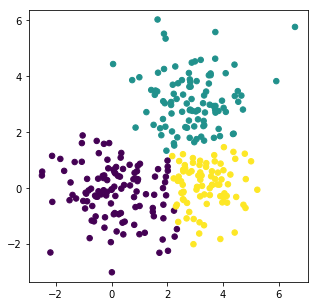

In [291]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)

plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()

Looks good! We can compare them visually with the groundtruth. To do: re-assign the labels to share the same ones with the groundtruth in order to compute an accuracy.

Remark: regarding the initialization, on the dummy dataset, we tend to have better results when $\mu$ is initialized with random data points from the dataset and $\Sigma_c$ initialiwed as the identity matrix.

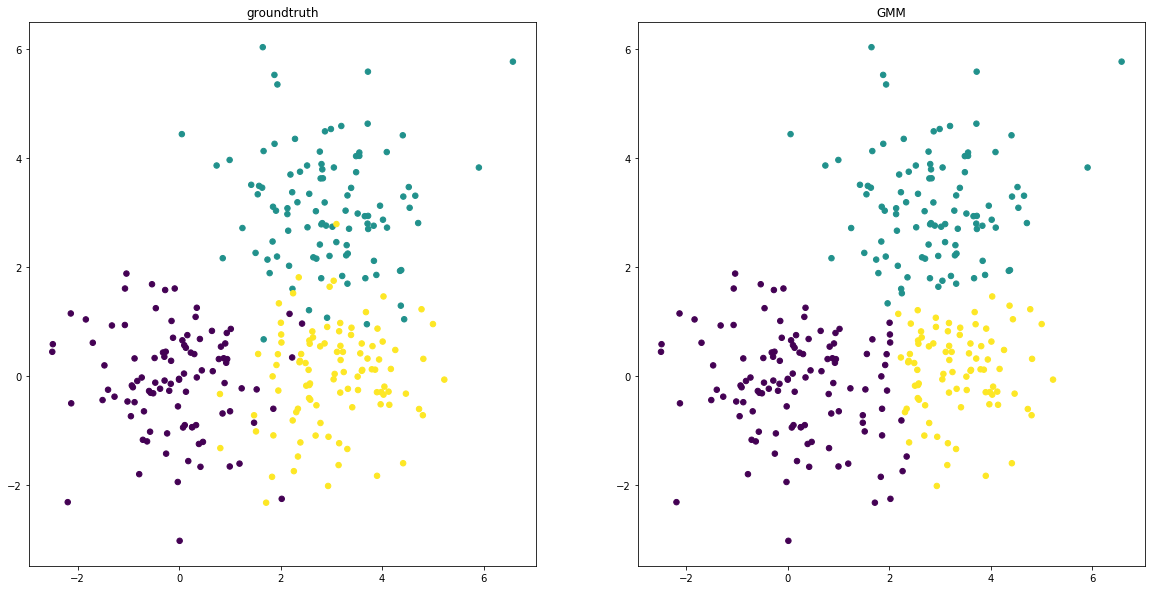

In [292]:
# plot the boundaries for the three pairs of classes
f, axarr = plt.subplots(1, 2, figsize=(20,10))
axarr[0].scatter(X[:, 0], X[:, 1], c=y, s=30)
axarr[0].set_title('groundtruth')
axarr[1].scatter(X[:, 0], X[:, 1], c=labels, s=30)
axarr[1].set_title('GMM')
plt.show()